# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#importing some useful packages
import cv2
from helper import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from pipeline import process_image

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


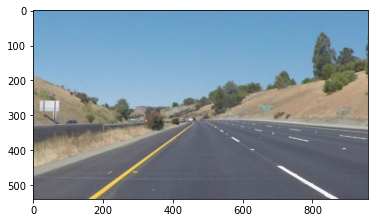

In [3]:
# Reading an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')

# Dimensions 
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', 
                   # for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
PATH = "test_images"
test_images = os.listdir(PATH)
test_images

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



I have build the pipeline in pipeline.py file

## Color Selection

/Users/robinredhu/CarND-LaneLines-P1-master/helper.py:150: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, i+1)


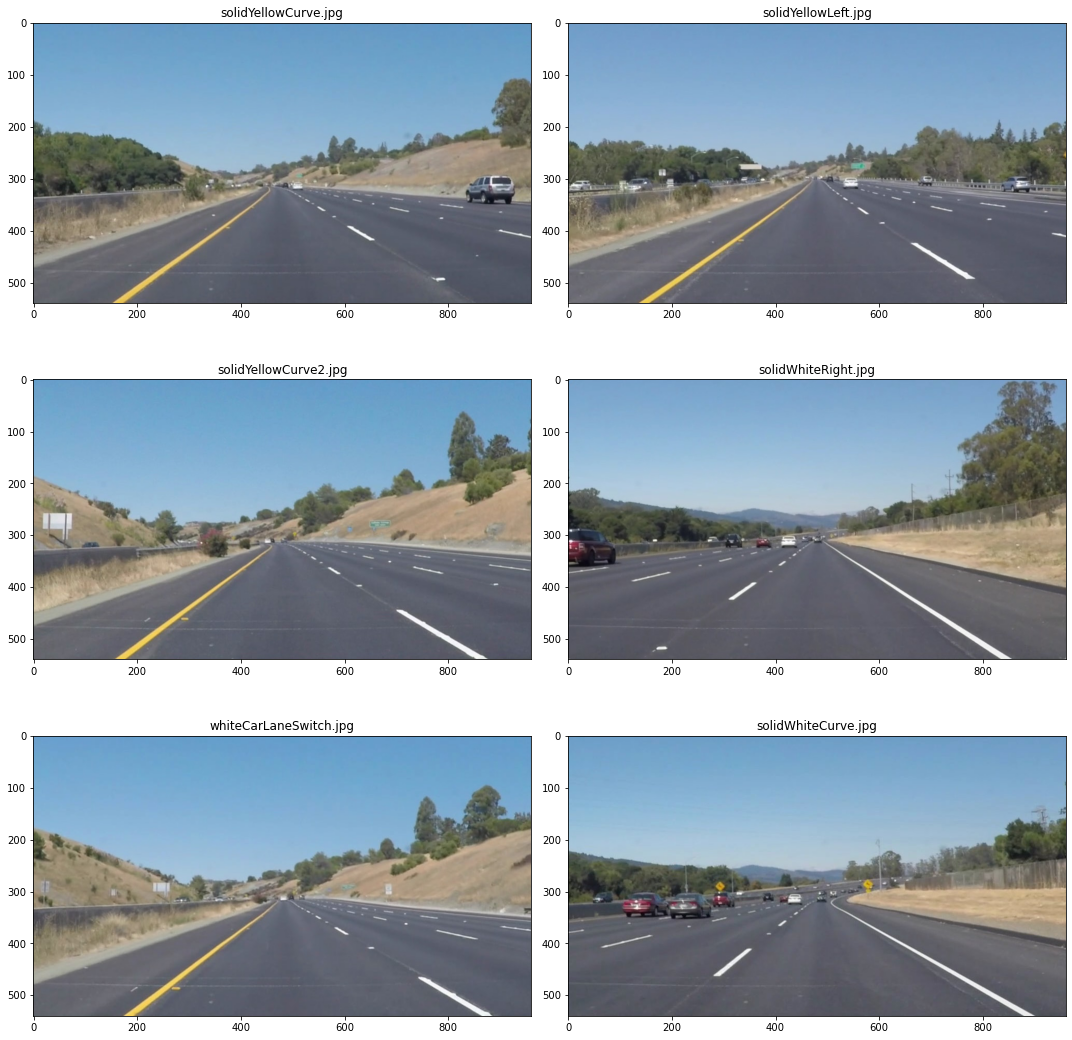

In [5]:
test_images = os.listdir("test_images/")
img_list = [mpimg.imread(PATH +"/" + name) for name in test_images]
display_imgs(img_list, test_images)
save_imgs(img_list, test_images, prefix= "Original")

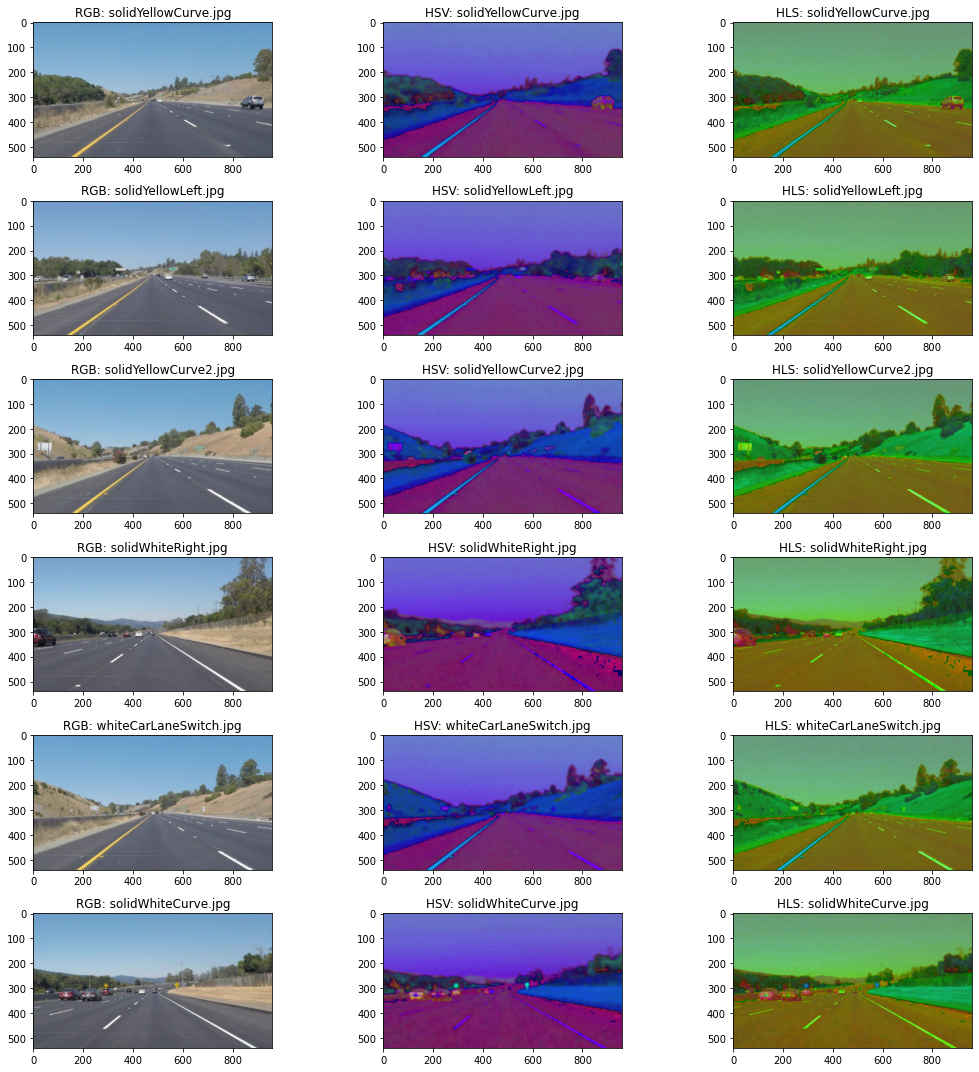

In [6]:
diff_color_spaces_imgs = []
diff_color_spaces_labels = []
for i in range(len(img_list)):
    diff_color_spaces_imgs.append(img_list[i])
    diff_color_spaces_labels.append("RGB: " +test_images[i])
    diff_color_spaces_imgs.append(to_hsv(img_list[i]))
    diff_color_spaces_labels.append("HSV: " +test_images[i])
    diff_color_spaces_imgs.append(to_hls(img_list[i]))
    diff_color_spaces_labels.append("HLS: " +test_images[i])
display_imgs(diff_color_spaces_imgs, diff_color_spaces_labels, cols=3)

In [7]:
original_imgs = np.copy(img_list)

# Pre Processing 

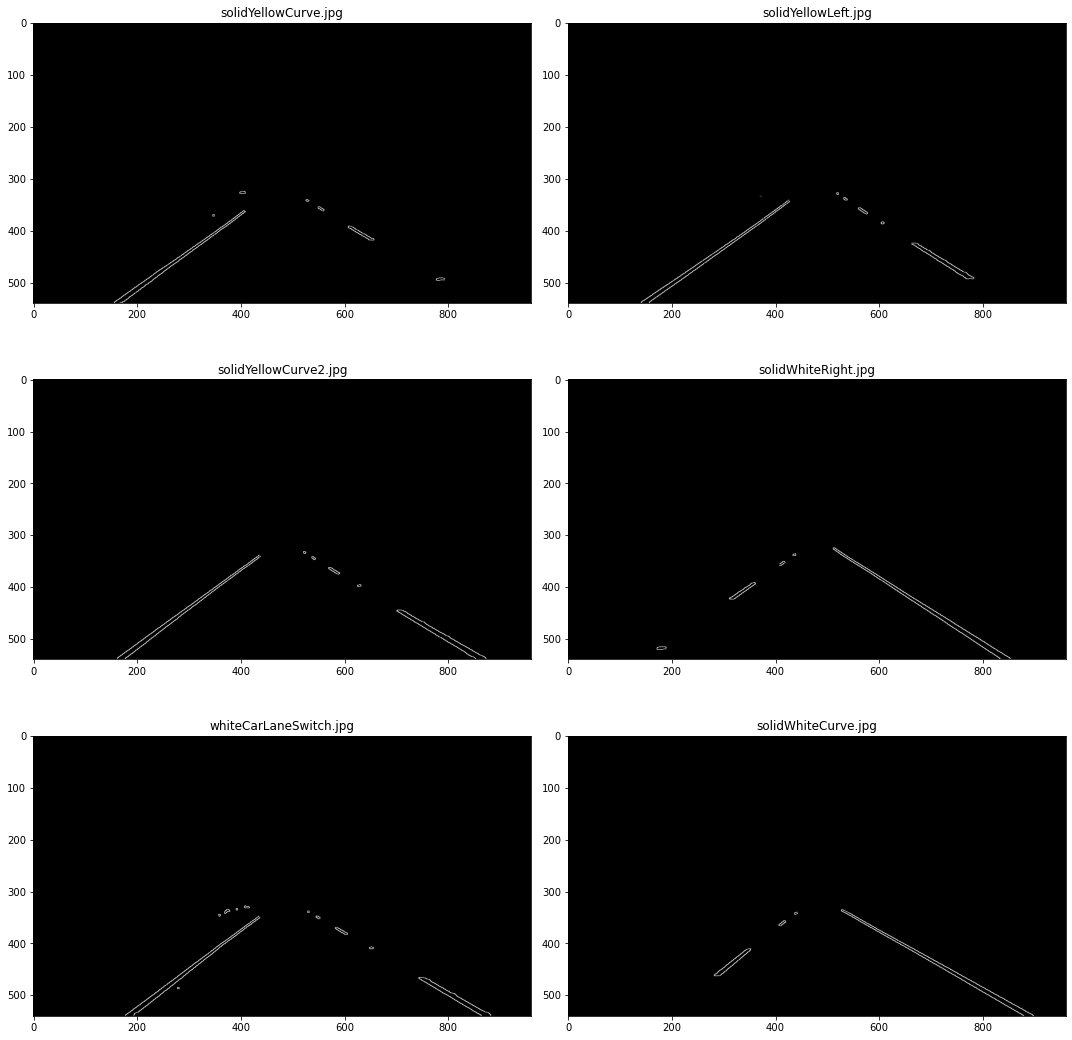

In [8]:
gray_imgs = [grayscale(img) for img in img_list]
darkened_imgs = [adjust_gamma(img, 0.5) for img in gray_imgs]
white_masks = [isolate_color_mask(img, np.array([210, 210, 210], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)) for img in img_list]
yellow_masks = [isolate_color_mask(img, np.array([190, 190, 0], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8)) for img in img_list]
masked_imgs = []
for i in range(len(img_list)):
    mask = cv2.bitwise_or(white_masks[i], yellow_masks[i])
    masked_imgs.append(cv2.bitwise_and(darkened_imgs[i], darkened_imgs[i], mask=mask))

blurred_imgs = [gaussian_blur(img, kernel_size=7) for img in masked_imgs]
canny_imgs = [canny(img, low_threshold=70, high_threshold=140) for img in blurred_imgs]
aoi_imgs = []
for img in canny_imgs:        
    aoi_imgs.append(get_aoi(img))
    
display_imgs(aoi_imgs, test_images)
save_imgs(aoi_imgs, test_images, prefix='AOI')

# Hough Transform Line Detection

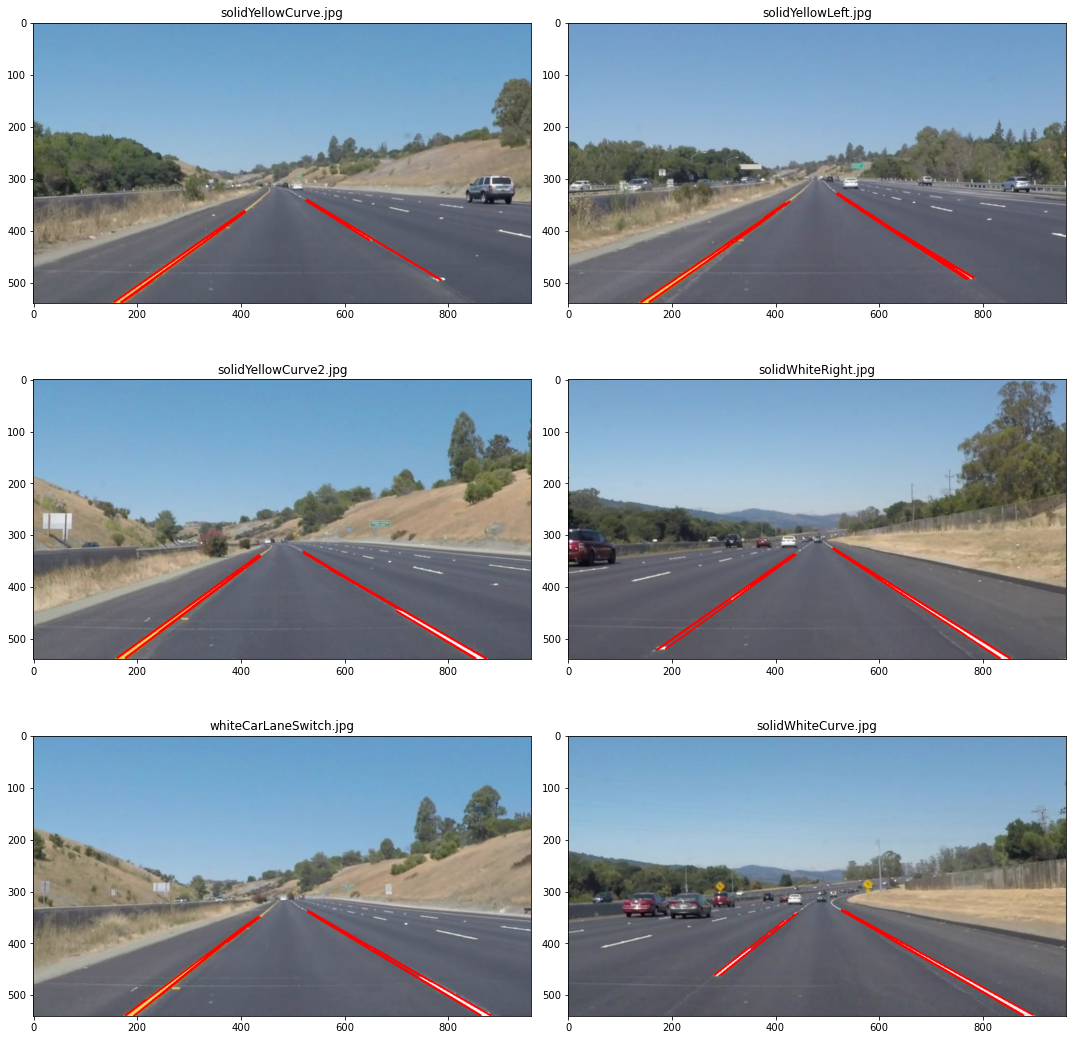

In [9]:
hough_lines_imgs = []
lines = []
rho=1
theta=np.pi/180
threshold=20
min_line_len=20
max_line_gap=300
for img in aoi_imgs:
    line = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines.append(line)
    line = None
    
for i in range(len(lines)):
    hough_lines_imgs.append(draw_lines(original_imgs[i], lines[i]))
    
display_imgs(hough_lines_imgs, test_images)
save_imgs(hough_lines_imgs, test_images, prefix='Hough')

# Averaging and Extrapolating Lines

Averaging is needed for multiple lines that are detected to come up with averaged line.

Extrapolation is needed for poartially recongined lane lines to extrapolate to complete lane line.

The left lane lines should have negative slope and the right lane lines should have positive slope.</br>
We'll ignore the verticle line (denominator in slope 0)</br>
We'll collect left lines and right lines based on line slope and the intercept based on formula b= y-mx</br>

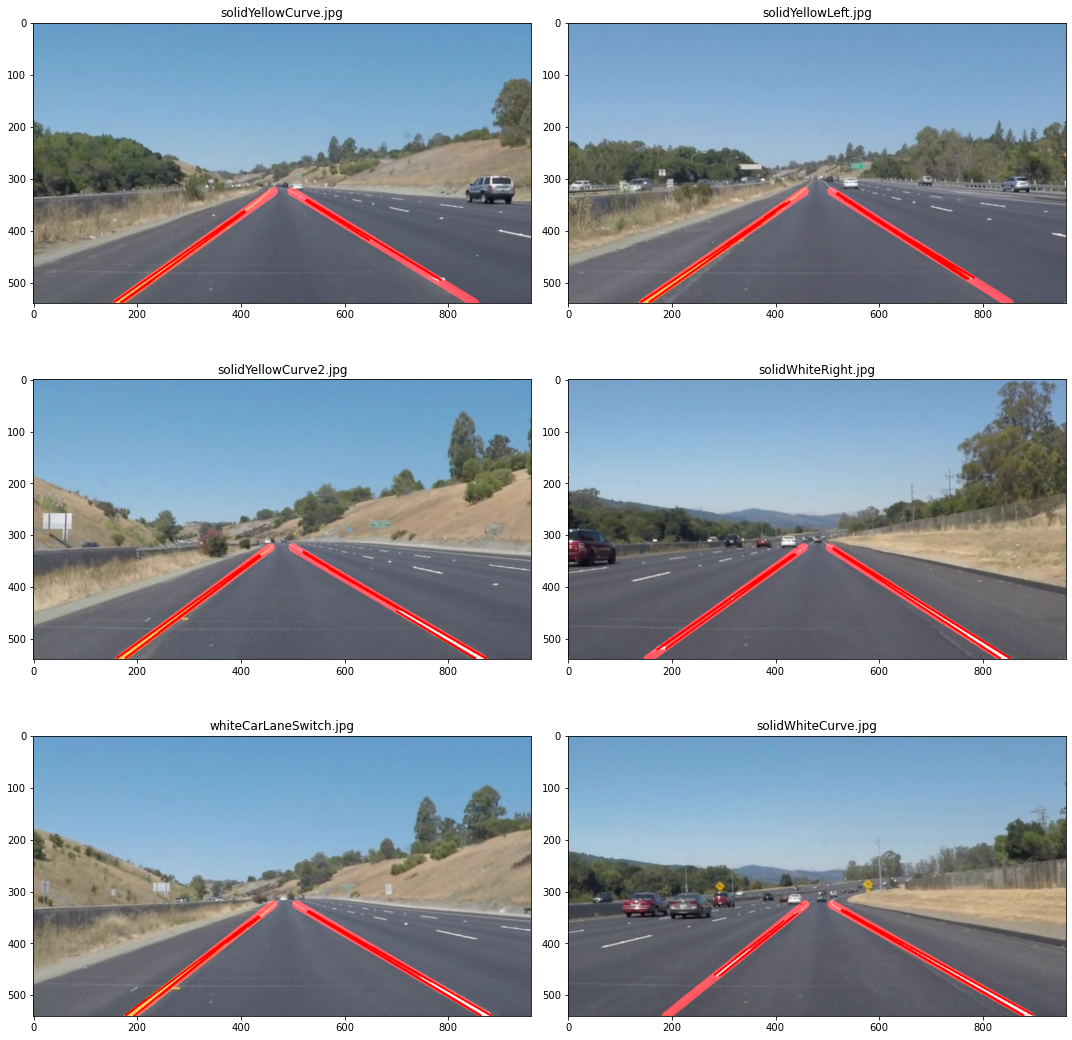

In [10]:
final_output =[]

for i in range(len(original_imgs)):
    left_lane, right_lane = get_lane_lines(original_imgs[i], lines[i])
    final_output.append(draw_weighted_lines(original_imgs[i], [left_lane, right_lane], thickness= 15))
    
display_imgs(final_output, test_images)
save_imgs(final_output, test_images, prefix='Final')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▌         | 12/221 [00:00<00:01, 117.36it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.28 s, sys: 453 ms, total: 3.73 s
Wall time: 3.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 10.7 s, sys: 1.3 s, total: 12 s
Wall time: 8.71 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   4%|▍         | 10/251 [00:00<00:02, 95.14it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 6.75 s, sys: 743 ms, total: 7.49 s
Wall time: 6.78 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))